In [1]:
# Install required libraries
# This cell ensures that all necessary packages are installed in the
# Colab or notebook environment.
!pip install gensim numpy scipy scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 68.0 MB/s eta 0:00:00


In [7]:
#  Force-create the 'bias_analyzer.py' library file

%%writefile bias_analyzer.py
#
# A Python module for analyzing and mitigating gender bias in static
# word embeddings. Implements methods from Bolukbasi et al. (2016),
# "Man is to Computer Programmer as Woman is to Homemaker? Debiasing
# Word Embeddings."

import numpy as np
from scipy import spatial
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#
# 1. GENDER DIRECTION COMPUTATION
#

def compute_gender_direction(embeddings, method='pca', definitional_pairs=None):
    """
    Computes the gender direction vector using specified method.
    """
    if definitional_pairs is None:
        definitional_pairs = [
            ('he', 'she'), ('man', 'woman'), ('boy', 'girl'),
            ('father', 'mother'), ('son', 'daughter'), ('husband', 'wife'),
            ('brother', 'sister'), ('uncle', 'aunt'), ('nephew', 'niece'),
            ('king', 'queen')
        ]

    if method == 'difference':
        print("Computing gender direction using 'difference' method (he - she)...")
        gender_vec = embeddings['he'] - embeddings['she']

    elif method == 'pca':
        print(f"Computing gender direction using 'pca' method with {len(definitional_pairs)} pairs...")
        differences = []
        for male_word, female_word in definitional_pairs:
            if male_word in embeddings and female_word in embeddings:
                diff = embeddings[male_word] - embeddings[female_word]
                differences.append(diff)
            else:
                print(f"Warning: Skipping pair ({male_word}, {female_word}) - not in vocabulary.")

        if len(differences) == 0:
            raise ValueError("No valid definitional pairs found in vocabulary.")

        diff_matrix = np.array(differences)
        pca = PCA(n_components=1)
        pca.fit(diff_matrix)
        gender_vec = pca.components_[0]

        explained_variance = pca.explained_variance_ratio_[0]
        print(f"PCA: 1st component explained variance: {explained_variance:.4f}")

    else:
        raise ValueError("Method must be 'difference' or 'pca'")

    gender_vec_normalized = gender_vec / np.linalg.norm(gender_vec)
    return gender_vec_normalized


def check_direction_stability(embeddings, definitional_pairs):
    """
    Performs a leave-one-out stability analysis on the gender direction.
    """
    print("\n--- Running Gender Direction Stability Analysis (Leave-One-Out) ---")

    original_direction = compute_gender_direction(
        embeddings,
        method='pca',
        definitional_pairs=definitional_pairs
    )

    similarities = []

    for i in range(len(definitional_pairs)):
        subset_pairs = definitional_pairs[:i] + definitional_pairs[i+1:]

        try:
            subset_direction = compute_gender_direction(
                embeddings,
                method='pca',
                definitional_pairs=subset_pairs
            )
            sim = cosine_similarity(original_direction, subset_direction)
            similarities.append(sim)
        except ValueError:
            print(f"  Skipping subset {i}, not enough valid pairs.")

    if not similarities:
        print("Could not complete stability analysis.")
        return

    mean_sim = np.mean(similarities)
    min_sim = np.min(similarities)

    print(f"Stability results (cosine similarity with full-set direction):")
    print(f"  Mean similarity: {mean_sim:.6f}")
    print(f"  Min similarity:  {min_sim:.6f}")
    print("--- Stability Analysis Complete ---")


#
# 2. DIRECT BIAS MEASUREMENT
#
def compute_direct_bias(embedding_vector, gender_direction):
    """
    Computes the direct bias of a word vector.
    """
    return np.dot(embedding_vector, gender_direction)


def analyze_words_bias(words, embeddings, gender_direction):
    """
    Analyzes and returns the direct bias for a list of words.
    """
    bias_scores = {}

    for word in words:
        if word in embeddings:
            vec = embeddings[word]
            bias = compute_direct_bias(vec, gender_direction)
            bias_scores[word] = bias
        else:
            print(f"Warning: '{word}' (for direct bias) not in vocabulary.")

    return bias_scores


def display_bias_results(bias_scores, top_n=10):
    """
    Prints a formatted table of the most biased words.
    """
    sorted_words = sorted(bias_scores.items(), key=lambda x: x[1], reverse=True)

    print(f"\n{'='*60}")
    print(f"DIRECT BIAS ANALYSIS (Top {top_n})")
    print(f"{'='*60}\n")

    print(f"Top {top_n} MASCULINE-biased words:")
    print(f"{'Word':<20} {'Bias Score':>15}")
    print("-" * 40)
    for word, score in sorted_words[:top_n]:
        print(f"{word:<20} {score:>15.6f}")

    print(f"\nTop {top_n} FEMININE-biased words:")
    print(f"{'Word':<20} {'Bias Score':>15}")
    print("-" * 40)
    for word, score in reversed(sorted_words[-top_n:]):
        print(f"{word:<20} {score:>15.6f}")
    print("\n")


#
# 3. WEAT (INDIRECT BIAS) MEASUREMENT
#
def cosine_similarity(vec1, vec2):
    """
    Computes cosine similarity between two vectors.
    """
    return 1 - spatial.distance.cosine(vec1, vec2)


def association_difference(word, set_A, set_B, embeddings):
    """
    Computes s(w, A, B) from the WEAT paper.
    """
    if word not in embeddings:
        return None

    word_vec = embeddings[word]

    similarities_A = [
        cosine_similarity(word_vec, embeddings[attr_word])
        for attr_word in set_A if attr_word in embeddings
    ]

    similarities_B = [
        cosine_similarity(word_vec, embeddings[attr_word])
        for attr_word in set_B if attr_word in embeddings
    ]

    if len(similarities_A) == 0 or len(similarities_B) == 0:
        return None

    mean_sim_A = np.mean(similarities_A)
    mean_sim_B = np.mean(similarities_B)

    return mean_sim_A - mean_sim_B


def weat_effect_size(target_set_X, target_set_Y, attribute_set_A,
                     attribute_set_B, embeddings):
    """
    Computes the WEAT test statistic and effect size (Cohen's d).
    """
    associations_X = [
        association_difference(word, attribute_set_A, attribute_set_B, embeddings)
        for word in target_set_X
    ]
    associations_Y = [
        association_difference(word, attribute_set_A, attribute_set_B, embeddings)
        for word in target_set_Y
    ]

    associations_X = [s for s in associations_X if s is not None]
    associations_Y = [s for s in associations_Y if s is not None]

    if len(associations_X) == 0 or len(associations_Y) == 0:
        raise ValueError("Not enough valid words in target sets to run WEAT.")

    test_statistic = np.sum(associations_X) - np.sum(associations_Y)

    mean_X = np.mean(associations_X)
    mean_Y = np.mean(associations_Y)

    all_associations = associations_X + associations_Y
    pooled_std = np.std(all_associations, ddof=1)

    if pooled_std == 0:
        effect_size = 0.0
    else:
        effect_size = (mean_X - mean_Y) / pooled_std

    return {
        'test_statistic': test_statistic,
        'effect_size': effect_size,
        'associations_X': associations_X,
        'associations_Y': associations_Y,
        'mean_X': mean_X,
        'mean_Y': mean_Y
    }


def weat_permutation_test(target_set_X, target_set_Y, attribute_set_A,
                          attribute_set_B, embeddings, n_permutations=1000):
    """
    Computes the p-value for WEAT using a permutation test.
    """
    try:
        observed_result = weat_effect_size(
            target_set_X, target_set_Y, attribute_set_A, attribute_set_B, embeddings
        )
    except ValueError as e:
        print(f"Error computing observed WEAT: {e}")
        return None, None

    observed_stat = observed_result['test_statistic']

    all_targets = list(target_set_X) + list(target_set_Y)
    n_X = len(target_set_X)
    np.random.seed(42)

    permuted_stats = []
    for _ in range(n_permutations):
        np.random.shuffle(all_targets)
        perm_X = all_targets[:n_X]
        perm_Y = all_targets[n_X:]

        try:
            perm_result = weat_effect_size(
                perm_X, perm_Y, attribute_set_A, attribute_set_B, embeddings
            )
            permuted_stats.append(perm_result['test_statistic'])
        except ValueError:
            continue

    p_value = np.mean(np.abs(permuted_stats) >= np.abs(observed_stat))

    return p_value, observed_result


#
# 4. BIAS MITIGATION (DEBIASING)
#

def debias_word_vector(word_vec, gender_direction):
    """
    Neutralizes bias in a single word vector using geometric projection.
    """
    projection_scalar = np.dot(word_vec, gender_direction)
    projection_vector = projection_scalar * gender_direction
    debiased_vec = word_vec - projection_vector
    return debiased_vec


#
# 5. VISUALIZATION
#
def plot_bias_distribution(bias_scores, title="Word Bias Distribution"):
    """
    Plots a histogram and bar chart for direct bias scores.
    """
    scores = list(bias_scores.values())
    if not scores:
        print(f"Cannot plot '{title}', no scores provided.")
        return

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(scores, bins=20, edgecolor='black', alpha=0.7)
    plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Neutral')
    plt.xlabel('Bias Score (Feminine <-> Masculine)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'{title}\nDistribution', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    sorted_items = sorted(bias_scores.items(), key=lambda x: x[1])

    num_display = min(10, len(sorted_items) // 2)
    if num_display < 1 and len(sorted_items) > 0:
         num_display = len(sorted_items)
    elif num_display == 0:
        plt.tight_layout()
        plt.show()
        return

    top_fem = sorted_items[:num_display]
    top_masc = sorted_items[-num_display:]

    selected_items = top_fem + top_masc
    selected_words = [w for w, _ in selected_items]
    selected_scores = [s for _, s in selected_items]

    colors = ['blue'] * num_display + ['red'] * num_display

    plt.barh(range(len(selected_words)), selected_scores, color=colors, alpha=0.7)
    plt.yticks(range(len(selected_words)), selected_words, fontsize=10)
    plt.xlabel('Bias Score', fontsize=12)
    plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
    plt.title('Most Biased Words', fontsize=14)
    plt.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()


def plot_weat_associations(results, target_X_name="Target X", target_Y_name="Target Y"):
    """
    Creates a box plot to visualize WEAT association differences.
    """
    if not results or 'associations_X' not in results or 'associations_Y' not in results:
        print("Cannot plot WEAT, results are incomplete.")
        return

    plt.figure(figsize=(8, 6))

    data = [results['associations_X'], results['associations_Y']]
    labels = [target_X_name, target_Y_name]

    bp = plt.boxplot(data, labels=labels, patch_artist=True, showmeans=False)

    colors = ['lightblue', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    means = [results['mean_X'], results['mean_Y']]
    plt.plot([1, 2], means, 'D', color='darkred', markersize=8, label='Mean', zorder=3)

    plt.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

    plt.ylabel('Association Difference\n(Assoc. w/ Male - Assoc. w/ Female)', fontsize=12)
    plt.title(f'WEAT Association Differences\nEffect Size (d) = {results["effect_size"]:.3f}',
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    plt.legend()
    plt.tight_layout()
    plt.show()

Overwriting bias_analyzer.py


In [8]:
# Import necessary libraries

import numpy as np
import gensim.downloader as api
from gensim.models import KeyedVectors
import copy
import warnings
import sys


import bias_analyzer as ba

warnings.filterwarnings('ignore')
print("Libraries imported successfully!")

Libraries imported successfully!


In [10]:
#  Load pre-trained word embeddings

# Configuration
# It can be changed to 'word2vec-google-news-300' or 'fasttext-wiki-news-subwords-300'
# to compare the bias in different models.
MODEL_NAME = 'glove-wiki-gigaword-100'


print(f"Loading {MODEL_NAME}... (This may take a few minutes on first download)")

# Use gensim's 'api.load' to download and load the model
try:
    # 'embeddings' will hold the loaded KeyedVectors object
    embeddings = api.load(MODEL_NAME)
    print(f"Model '{MODEL_NAME}' loaded successfully.")
    print(f"Vocabulary size: {len(embeddings)} words")
    print(f"Embedding dimension: {embeddings.vector_size}")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please check your internet connection or the model name.")

Loading glove-wiki-gigaword-100... (This may take a few minutes on first download)
[==================================================] 100.0% 128.1/128.1MB downloaded
Model 'glove-wiki-gigaword-100' loaded successfully.
Vocabulary size: 400000 words
Embedding dimension: 100


**Phase A: Quantifying Bias in the Original Model**

In this phase, we will analyze the original, untouched word embedding model. We will:

1.Define the Gender Subspace using PCA and test its stability.

2.Measure Direct Bias in occupation-related words.

3.Measure Indirect Bias using two standard WEAT (Word Embedding Association Test) setups.

In [13]:
#  Compute Gender Direction & Stability

print("[Phase A] Starting Bias Quantification ")
print("Step 1: Computing Gender Direction...")

# Define the set of word pairs that define gender
# (from Bolukbasi et al., 2016)
DEFINITIONAL_PAIRS = [
    ('he', 'she'), ('man', 'woman'), ('boy', 'girl'),
    ('father', 'mother'), ('son', 'daughter'), ('husband', 'wife'),
    ('brother', 'sister'), ('uncle', 'aunt'), ('nephew', 'niece'),
    ('king', 'queen')
]

# 1. Compute the main gender direction vector using PCA
# This calls the custom function from 'bias_analyzer.py'
gender_direction = ba.compute_gender_direction(
    embeddings,
    method='pca',
    definitional_pairs=DEFINITIONAL_PAIRS
)
print(f"\nGender direction computed (shape: {gender_direction.shape})")


# 2.Run stability analysis
# This confirms our gender_direction is robust.
ba.check_direction_stability(embeddings, DEFINITIONAL_PAIRS)

[Phase A] Starting Bias Quantification 
Step 1: Computing Gender Direction...
Computing gender direction using 'pca' method with 10 pairs...
PCA: 1st component explained variance: 0.2403

Gender direction computed (shape: (100,))

--- Running Gender Direction Stability Analysis (Leave-One-Out) ---
Computing gender direction using 'pca' method with 10 pairs...
PCA: 1st component explained variance: 0.2403
Computing gender direction using 'pca' method with 9 pairs...
PCA: 1st component explained variance: 0.2661
Computing gender direction using 'pca' method with 9 pairs...
PCA: 1st component explained variance: 0.2741
Computing gender direction using 'pca' method with 9 pairs...
PCA: 1st component explained variance: 0.2516
Computing gender direction using 'pca' method with 9 pairs...
PCA: 1st component explained variance: 0.2549
Computing gender direction using 'pca' method with 9 pairs...
PCA: 1st component explained variance: 0.2496
Computing gender direction using 'pca' method with 9


Step 2: Measuring Direct Bias in Occupations...

DIRECT BIAS ANALYSIS (Top 10)

Top 10 MASCULINE-biased words:
Word                      Bias Score
----------------------------------------
secretary                   1.566483
lawyer                      1.495397
professor                   1.431653
doctor                      1.037052
scientist                   0.901173
engineer                    0.862321
carpenter                   0.673728
teacher                     0.501274
musician                    0.483309
mechanic                    0.439941

Top 10 FEMININE-biased words:
Word                      Bias Score
----------------------------------------
dancer                     -0.834829
homemaker                  -0.706697
receptionist               -0.651284
babysitter                 -0.619549
nurse                      -0.408701
chef                       -0.077717
electrician                 0.029075
artist                      0.035223
programmer                  0.24895

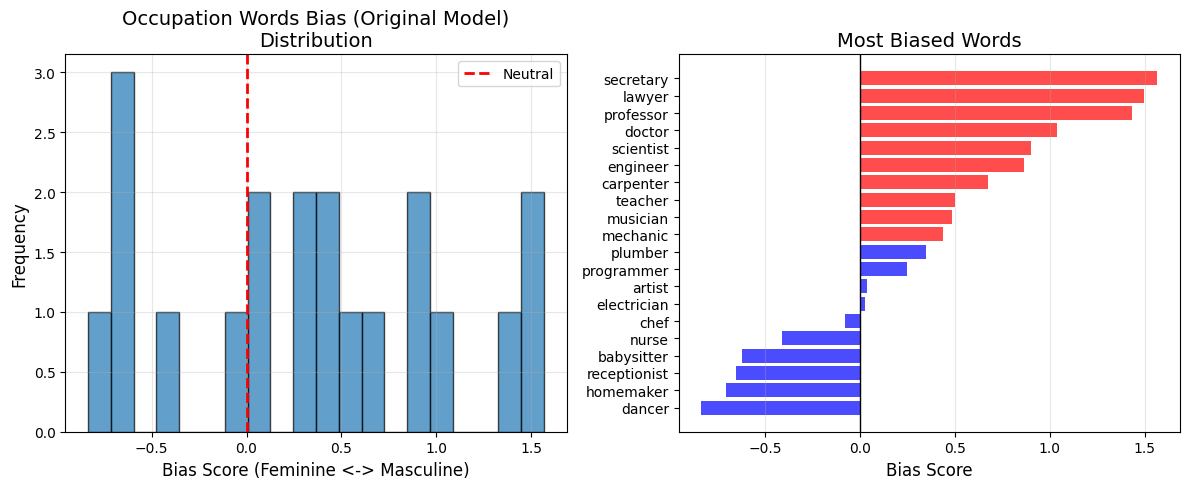

In [14]:
# Analysis 1 - Direct Bias (Occupations)

print("\nStep 2: Measuring Direct Bias in Occupations...")

# A list of stereotypically gendered and neutral occupations
OCCUPATION_WORDS = [
    'programmer', 'engineer', 'scientist', 'doctor', 'nurse',
    'teacher', 'professor', 'lawyer', 'secretary', 'receptionist',
    'mechanic', 'electrician', 'carpenter', 'plumber', 'chef',
    'homemaker', 'babysitter', 'dancer', 'artist', 'musician'
]

# 1. Calculate bias scores for each word
# This projects each word vector onto the gender_direction
original_bias_scores = ba.analyze_words_bias(
    OCCUPATION_WORDS,
    embeddings,
    gender_direction
)

# 2. Display text results in a formatted table
ba.display_bias_results(original_bias_scores, top_n=10)

# 3. Plot graphical results (histogram and bar chart)
ba.plot_bias_distribution(original_bias_scores, "Occupation Words Bias (Original Model)")


Step 3: Measuring Indirect Bias (WEAT 1 - Career vs. Family)...

WEAT 1 Results (Career vs. Family):
  Test Statistic:    1.7323
  Effect Size (d):   1.6648
  P-value:           0.0010
  ✓ SIGNIFICANT BIAS DETECTED (p < 0.05)


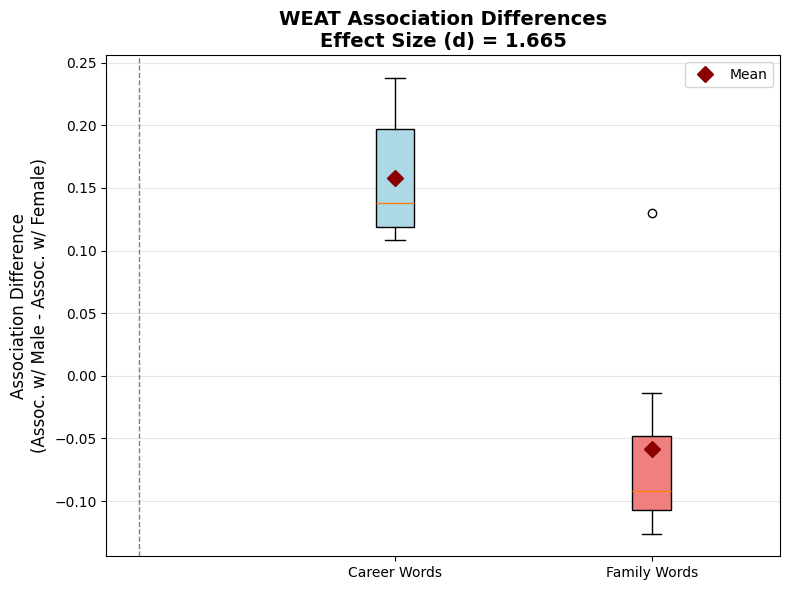

In [15]:
#  Analysis 2 - WEAT (Career vs. Family)

print("\nStep 3: Measuring Indirect Bias (WEAT 1 - Career vs. Family)...")

# This test measures the association between 'Career' words and 'Male' names
# vs. 'Family' words and 'Female' names.

# Define attribute sets (Male vs. Female names)
MALE_NAMES = ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill']
FEMALE_NAMES = ['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna']

# Define target sets (Career vs. Family)
CAREER_WORDS = [
    'executive', 'management', 'professional', 'corporation',
    'salary', 'office', 'business', 'career'
]
FAMILY_WORDS = [
    'home', 'parents', 'children', 'family',
    'cousins', 'marriage', 'wedding', 'relatives'
]

# 1. Run the permutation test (calculates p-value and effect size)
p_val_career, res_career = ba.weat_permutation_test(
    target_set_X=CAREER_WORDS,
    target_set_Y=FAMILY_WORDS,
    attribute_set_A=MALE_NAMES,
    attribute_set_B=FEMALE_NAMES,
    embeddings=embeddings,
    n_permutations=1000  # 1000 is fast, 10000+ is more robust
)

# 2. Print and plot results
if p_val_career is not None:
    print(f"\nWEAT 1 Results (Career vs. Family):")
    print(f"  Test Statistic:    {res_career['test_statistic']:.4f}")
    print(f"  Effect Size (d):   {res_career['effect_size']:.4f}")
    print(f"  P-value:           {p_val_career:.4f}")

    if p_val_career < 0.05:
        print("  ✓ SIGNIFICANT BIAS DETECTED (p < 0.05)")
    else:
        print("  ✗ No significant bias detected (p >= 0.05)")

    # 3. Plot the association distributions
    ba.plot_weat_associations(res_career, "Career Words", "Family Words")
else:
    print("Could not run WEAT 1: Check word lists and model vocabulary.")


Step 4: Measuring Indirect Bias (WEAT 2 - Science vs. Arts)...

WEAT 2 Results (Science vs. Arts):
  Test Statistic:    0.7160
  Effect Size (d):   1.1243
  P-value:           0.0130
   SIGNIFICANT BIAS DETECTED (p < 0.05)


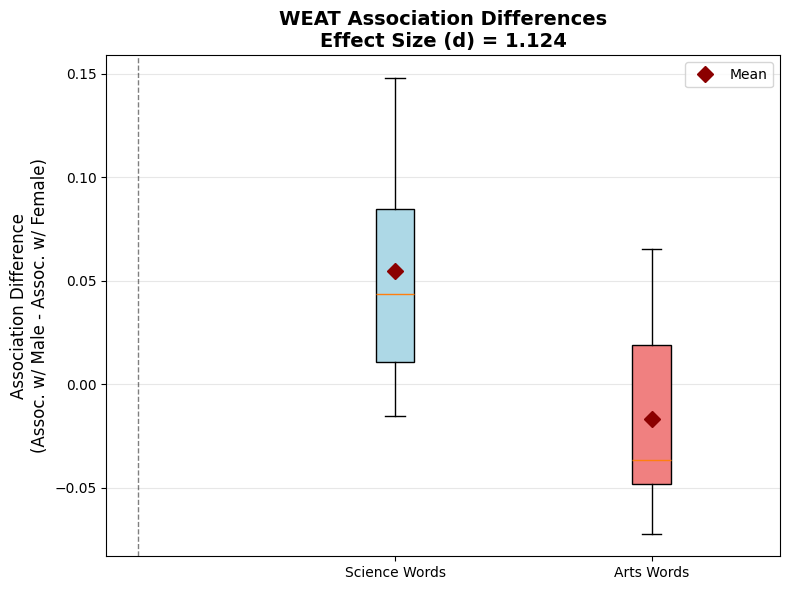

In [17]:
# Analysis 3 - WEAT (Science vs. Arts)

print("\nStep 4: Measuring Indirect Bias (WEAT 2 - Science vs. Arts)...")

# This test measures the association between 'Science' words and 'Male' names
# vs. 'Arts' words and 'Female' names.

# Define target sets (Science vs. Arts)
SCIENCE_WORDS = [
    'science', 'technology', 'physics', 'chemistry', 'math',
    'algebra', 'geology', 'astronomy', 'engineer', 'experiment'
]
ARTS_WORDS = [
    'poetry', 'art', 'dance', 'literature', 'novel',
    'symphony', 'drama', 'sculpture', 'music', 'painting'
]

# 1. Run the permutation test
p_val_sci, res_sci = ba.weat_permutation_test(
    target_set_X=SCIENCE_WORDS,
    target_set_Y=ARTS_WORDS,
    attribute_set_A=MALE_NAMES,
    attribute_set_B=FEMALE_NAMES,
    embeddings=embeddings,
    n_permutations=1000
)

# 2. Print and plot results
if p_val_sci is not None:
    print(f"\nWEAT 2 Results (Science vs. Arts):")
    print(f"  Test Statistic:    {res_sci['test_statistic']:.4f}")
    print(f"  Effect Size (d):   {res_sci['effect_size']:.4f}")
    print(f"  P-value:           {p_val_sci:.4f}")

    if p_val_sci < 0.05:
        print("   SIGNIFICANT BIAS DETECTED (p < 0.05)")
    else:
        print("   No significant bias detected (p >= 0.05)")

    # 3. Plot the association distributions
    ba.plot_weat_associations(res_sci, "Science Words", "Arts Words")
else:
    print("Could not run WEAT 2: Check word lists and model vocabulary.")

**Phase B:**
Bias Mitigation (Debiasing)

Having quantified the bias, we now attempt to mitigate it. We will:

1.   Create a debiased copy of the embedding model.
2.   Neutralize all non-gender-specific words
(occupations, career, science, arts) by removing their projection onto the gender axis.


The mathematical operation is : $v_{debiased} = v_{original} - (v_{original} \cdot v_{gender}) \cdot v_{gender}$

In [18]:
# Cell 8: Create Debiased Model

print("\n[Phase B] Starting Bias Mitigation ")

# 1. Create a DEEP COPY of the embeddings
# This is critical. We want to preserve the original 'embeddings'
# model for comparison.
print("Creating a deep copy of the model...")
debiased_embeddings = copy.deepcopy(embeddings)

# 2. Define all words we want to neutralize
# Combine all target words from our previous tests
words_to_debias = set(OCCUPATION_WORDS + CAREER_WORDS + FAMILY_WORDS +
                      SCIENCE_WORDS + ARTS_WORDS)
print(f"Identified {len(words_to_debias)} unique words to neutralize.")

# 3. Loop, debias, and overwrite the vectors in the NEW model
count = 0
for word in words_to_debias:
    if word in debiased_embeddings:
        # Get the original (biased) vector from our new model
        original_vec = debiased_embeddings[word]

        # Calculate the new (debiased) vector using our library function
        debiased_vec = ba.debias_word_vector(original_vec, gender_direction)

        # Overwrite the vector in our 'debiased_embeddings' model
        debiased_embeddings[word] = debiased_vec
        count += 1

print(f"Successfully debiased {count} word vectors.")


[Phase B] Starting Bias Mitigation 
Creating a deep copy of the model...
Identified 55 unique words to neutralize.
Successfully debiased 55 word vectors.


**Phase C: Verification of Debiasing**

This is the most important step: did our fix work?

We will now re-run the exact same tests from Phase A, but using our new debiased_embeddings model.
 We expect:



1.   Direct Bias scores to be $\approx 0$.
2.   WEAT effect sizes and p-values to be significantly reduced.






[Phase C] Verifying Debiasing (Direct Bias)

DIRECT BIAS ANALYSIS (Top 10)

Top 10 MASCULINE-biased words:
Word                      Bias Score
----------------------------------------
receptionist                0.000000
professor                   0.000000
lawyer                      0.000000
artist                      0.000000
nurse                       0.000000
doctor                      0.000000
homemaker                   0.000000
engineer                    0.000000
dancer                      0.000000
electrician                 0.000000

Top 10 FEMININE-biased words:
Word                      Bias Score
----------------------------------------
secretary                  -0.000000
plumber                    -0.000000
scientist                  -0.000000
carpenter                  -0.000000
babysitter                 -0.000000
chef                       -0.000000
programmer                 -0.000000
teacher                    -0.000000
musician                    0.000000
me

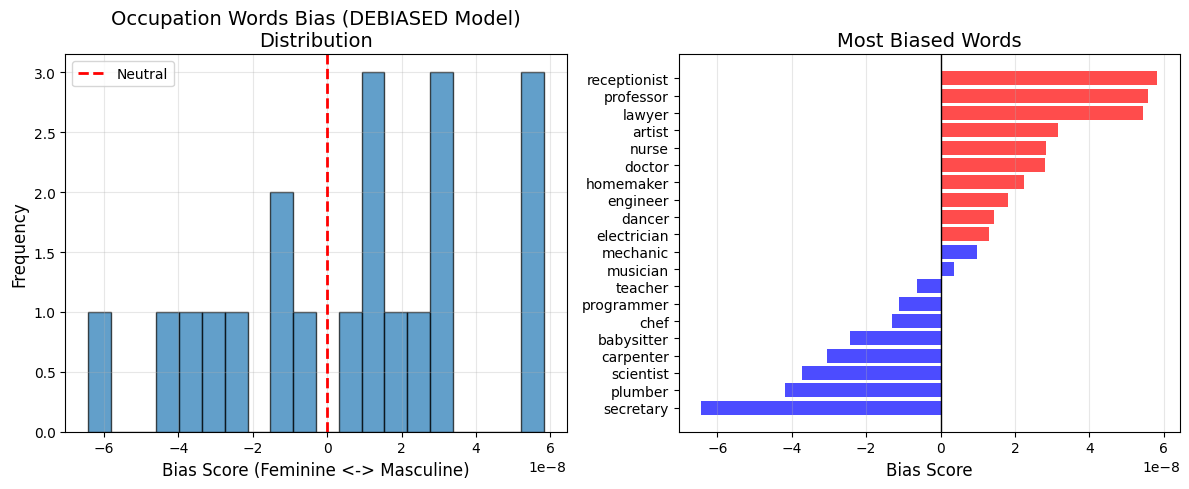

In [19]:
# Verification 1 - Direct Bias (Occupations)

print("\n[Phase C] Verifying Debiasing (Direct Bias)")

# 1. Calculate bias scores using the DEBIASED model
debiased_bias_scores = ba.analyze_words_bias(
    OCCUPATION_WORDS,
    debiased_embeddings,  # <-- Using the new model
    gender_direction
)

# 2. Display text results
# We expect all scores to be 0.000000 (or very close, like 1e-17)
ba.display_bias_results(debiased_bias_scores, top_n=10)

# 3. Plot graphical results
# The histogram should be a single spike at 0
ba.plot_bias_distribution(debiased_bias_scores, "Occupation Words Bias (DEBIASED Model)")


 [Phase C] Verifying Debiasing (WEAT 1) 

WEAT 1 Results (Debiased):
  Test Statistic:    1.7735
  Effect Size (d):   1.6980
  P-value:           0.0010

Comparison (Career vs. Family) 
  Original Effect Size: 1.6648 (p=0.0010)
  Debiased Effect Size: 1.6980 (p=0.0010)


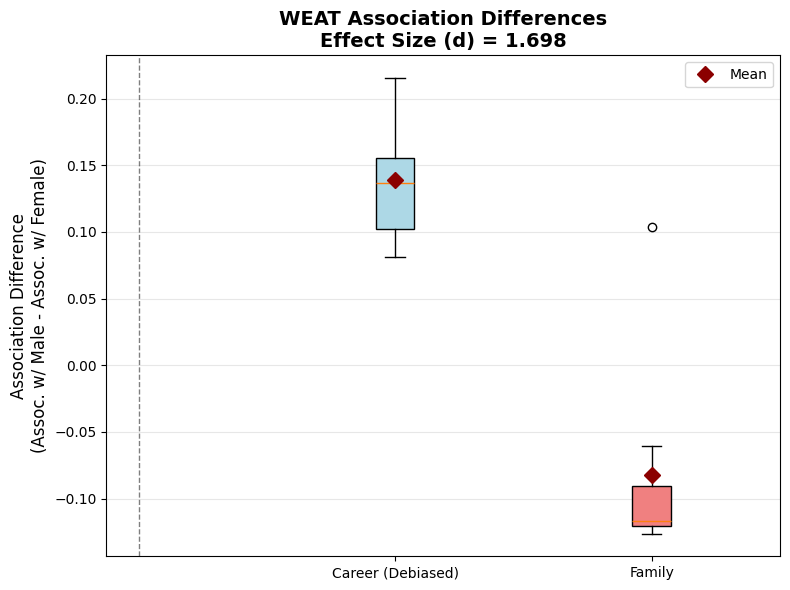

In [20]:
#  Verification 2 - WEAT (Career vs. Family)

print("\n [Phase C] Verifying Debiasing (WEAT 1) ")

# 1. Run the permutation test using the DEBIASED model
p_val_career_db, res_career_db = ba.weat_permutation_test(
    target_set_X=CAREER_WORDS,
    target_set_Y=FAMILY_WORDS,
    attribute_set_A=MALE_NAMES,
    attribute_set_B=FEMALE_NAMES,
    embeddings=debiased_embeddings, # <-- Using the new model
    n_permutations=1000
)

# 2. Print and plot results
if p_val_career_db is not None:
    print(f"\nWEAT 1 Results (Debiased):")
    print(f"  Test Statistic:    {res_career_db['test_statistic']:.4f}")
    print(f"  Effect Size (d):   {res_career_db['effect_size']:.4f}")
    print(f"  P-value:           {p_val_career_db:.4f}")

    print("\nComparison (Career vs. Family) ")
    print(f"  Original Effect Size: {res_career['effect_size']:.4f} (p={p_val_career:.4f})")
    print(f"  Debiased Effect Size: {res_career_db['effect_size']:.4f} (p={p_val_career_db:.4f})")

    # 3. Plot the new distributions
    ba.plot_weat_associations(res_career_db, "Career (Debiased)", "Family")
else:
    print("Could not run debiased WEAT 1.")


 [Phase C] Verifying Debiasing (WEAT 2) 

WEAT 2 Results (Debiased):
  Test Statistic:    0.6306
  Effect Size (d):   1.0060
  P-value:           0.0260

 Comparison (Science vs. Arts) 
  Original Effect Size: 1.1243 (p=0.0130)
  Debiased Effect Size: 1.0060 (p=0.0260)


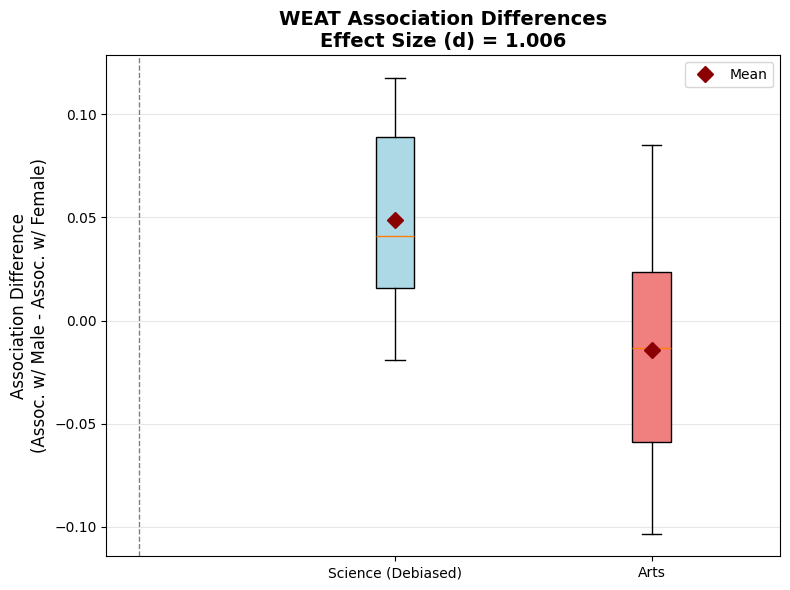

In [21]:
# Verification 3 - WEAT (Science vs. Arts)

print("\n [Phase C] Verifying Debiasing (WEAT 2) ")

# 1. Run the permutation test using the DEBIASED model
p_val_sci_db, res_sci_db = ba.weat_permutation_test(
    target_set_X=SCIENCE_WORDS,
    target_set_Y=ARTS_WORDS,
    attribute_set_A=MALE_NAMES,
    attribute_set_B=FEMALE_NAMES,
    embeddings=debiased_embeddings, # <-- Using the new model
    n_permutations=1000
)

# 2. Print and plot results
if p_val_sci_db is not None:
    print(f"\nWEAT 2 Results (Debiased):")
    print(f"  Test Statistic:    {res_sci_db['test_statistic']:.4f}")
    print(f"  Effect Size (d):   {res_sci_db['effect_size']:.4f}")
    print(f"  P-value:           {p_val_sci_db:.4f}")

    print("\n Comparison (Science vs. Arts) ")
    print(f"  Original Effect Size: {res_sci['effect_size']:.4f} (p={p_val_sci:.4f})")
    print(f"  Debiased Effect Size: {res_sci_db['effect_size']:.4f} (p={p_val_sci_db:.4f})")

    # 3. Plot the new distributions
    ba.plot_weat_associations(res_sci_db, "Science (Debiased)", "Arts")
else:
    print("Could not run debiased WEAT 2.")